In [2]:
from astropy.coordinates import SkyCoord, Galactocentric, Galactic
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import minimize
import pandas as pd

plt.rc('font',family='serif')
plt.rc('text',usetex=True)

In [3]:
mainSeqStars = fits.open("fits_table/new_full_data.fits") #,memmap=True)
MSSdata = mainSeqStars[1].data
newMSSdata = MSSdata.newbyteorder().byteswap()  
df = pd.DataFrame(newMSSdata)
MainSeqQuery = df.query('MainSeqStar == True')
print(len(MainSeqQuery))
print(len(MSSdata))

# select a sub group
# df = df.query("bp_rp-e_bp_min_rp_val < 0.8") #& bp_rp-e_bp_min_rp_val <1.2")
# df = df.query("bp_rp-e_bp_min_rp_val >=0.8 & bp_rp-e_bp_min_rp_val <1.2")
df = df.query("bp_rp-e_bp_min_rp_val >=1.2 & bp_rp-e_bp_min_rp_val <1.6")

6158038
12899067


In [4]:
## solar velocity 1.2-1.6
u0 = 10.07#*u.km/u.s #km*s-1
v0 = 25.14#*u.km/u.s #km*s-1
w0 = 7.92#*u.km/u.s

## find $\Delta \mu_l$

In [5]:
data = df.query("b>-20 & b<20")
print(len(data))
l = np.array(data['l'])
b = np.array(data['b'])
ra = np.array(data['ra'])#*u.deg)
dec = np.array(data['dec'])#*u.deg)
pm_ra_cosdec = np.array(data['pmra'])#*u.mas/u.yr)
pm_dec = np.array(data['pmdec'])#*u.mas/u.yr)
radial_velocity = np.array(data['radial_velocity'])#*u.km/u.s)
parallax = np.array(data['parallax'])

# define Skycoord 
skycoords = SkyCoord(ra =ra*u.deg, dec = dec*u.deg,\
                     pm_ra_cosdec=pm_ra_cosdec*u.mas/u.yr, pm_dec=pm_dec*u.mas/u.yr, \
                     frame='icrs')

galcen = skycoords.transform_to(Galactic) #convert to Galactic coord

mu_b = galcen.pm_b * 4.74047 / u.mas * u.yr#units of from mas yr-1 to units of km s-1 kpc-1 
mu_l = galcen.pm_l_cosb * 4.74047 / u.mas * u.yr# * u.km/ u.s / u.kpc#convert from units of from mas yr-1 to units of km s-1 kpc-1

distance=np.array(1/data['parallax'])#*u.kpc)

print(len(mu_l))

mu_l_corrected = 1/np.cos(np.radians(b))*(mu_l-parallax*(u0*np.sin(np.radians(l))-v0*np.cos(np.radians(l))))

584908
584908


In [7]:
# sort mu_l into l intevral of 1 degree
q_df_data = {'l':data['l'],
            'mu_l': mu_l_corrected}
q_df = pd.DataFrame(q_df_data,columns=['l','mu_l'])
l_bin = np.arange(0,361,1)
binned = [[] for _ in range(360)]
for j in np.arange(0,360,1):
    qstr = 'l >= %f & l<%f'%(l_bin[j],l_bin[j+1])
    binned[j] = q_df.query(qstr)['mu_l']
    
delta_mu_l_mean = list(map(lambda i: np.mean(i), binned))
xdata = np.arange(0,360,1)
ydata = delta_mu_l_mean

### compare: using how many data to fit the function:

maximiz likelihood fitting method and compare likelihood

In [8]:
def mu_l_func(l,A,B,C):
    return A*np.cos(np.radians(2*l))-C*np.sin(np.radians(2*l))+B

In [9]:
def predict_func(params):
    A = params[0]
    B = params[1]
    C = params[2]
    sd = params[3]
    
    yPred = A*np.cos(np.radians(2*x)) - C*np.sin(np.radians(2*x))+B
    
    # log-likely function
    LL = - np.sum(stats.norm.logpdf(y,loc=yPred,scale=sd))
#     print(-1*LL)
    return LL

initParams = [15,-11,-3,1]

def fit(func, guess):
    soln = minimize(func, guess, method = 'Nelder-Mead') 
    return soln.x 

##### using all 360 pairs of (l, mu_l):

In [11]:
x = xdata
y = ydata

A,B,C,std = fit(predict_func,initParams)
params1 = [A,B,C,std]
LL1 = predict_func(params1)
print("minimize this negative ln Likelihood: ",LL1)
print("A,B,C: ",A,B,C)
xfit = np.linspace(0,360,361)
popt1 = params1[:3]
yPred1 = mu_l_func(xfit,*popt1)

minimize this negative ln Likelihood:  1157.65408074901
A,B,C:  15.798809995462676 -12.488655909289008 -2.8033771194384856


##### Using 10 data points

In [13]:
x = xdata[::36]
y = ydata[::36]

A,B,C,std = fit(predict_func,initParams)
params2 = [A,B,C,std]
LL2 = predict_func(params2)
print("minimize this negative ln Likelihood: ",LL2)
print("A,B,C: ",A,B,C)

xfit = np.linspace(0,360,361)
popt2 = params2[:3]
yPred2 = mu_l_func(xfit,*popt2)

minimize this negative ln Likelihood:  29.230649711210003
A,B,C:  15.124995331006978 -10.792703899456642 -0.9647062751198721


#### Compare fitting results

minimized lnL:  1157.65408074901  > 29.230649711210003
using 360 points:  [15.798809995462676, -12.488655909289008, -2.8033771194384856]
using 10 points like Li:  [15.124995331006978, -10.792703899456642, -0.9647062751198721]


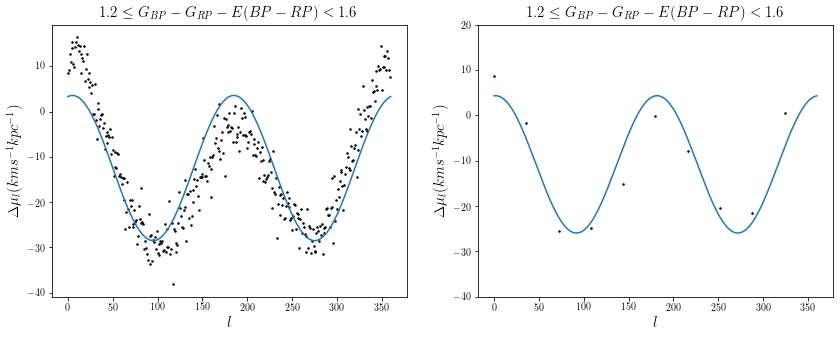

In [14]:
f,ax = plt.subplots(1,2,figsize=(14,5))
ax[0].plot(xdata,ydata,'k.',markersize=3,label="binned$<\mu_l>$")
ax[0].plot(xfit,yPred1,'-',label="fit")
plt.ylim(-40,20)
ax[0].set_title("$1.2\\leq G_{BP}-G_{RP}-E(BP-RP)<1.6$",fontsize=15)
ax[0].set_xlabel("$l$",fontsize=15)
ax[0].set_ylabel('$\Delta \mu _l(kms^{-1}kpc^{-1})$',fontsize=15)


plt.subplot(1,2,2)
plt.plot(xdata[::36],ydata[::36],'k.',markersize=3,label="binned$<\mu_l>$")
plt.plot(xfit,yPred2,'-',label="fit")
plt.ylim(-40,20)
plt.title("$1.2\\leq G_{BP}-G_{RP}-E(BP-RP)<1.6$",fontsize=15)
plt.xlabel("$l$",fontsize=15)
plt.ylabel('$\Delta \mu _l(kms^{-1}kpc^{-1})$',fontsize=15)
plt.savefig('plot/compare_fit.png')
print("minimized lnL: ",LL1, " >", LL2)
print("using 360 points: ", params1[:3])
print("using 10 points like Li: ", params2[:3])